## InfluxDB data handling integration
Instead of using csv as input file, we'll use the influxDB api to load in the data. Then we can use the machine learning model to disagregate it and write the new data back into influx. Reference on influxDB API here: https://www.influxdata.com/blog/time-series-forecasting-with-tensorflow-influxdb/

In [ ]:
! pip install influxdb-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.0/744.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 31.2 MB/s eta 0:00:00


Library dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List of CSV files to use for training
#
csv_files = ['/content/drive/MyDrive/Colab Notebooks/15minute_data_california.csv']  # Add more file names as needed

# Load and concatenate data from multiple CSV files
data_list = []
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data_list.append(data)

# Concatenate data from all CSV files
data = pd.concat(data_list, ignore_index=True)

This prints the orignal data from the CSV file

In [ ]:
data

,dataid,local_15min,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,sprinkler1,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1,leg1v,leg2v
0,3687,2014-01-01 00:00:00-06,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.239,119.769
1,3687,2014-01-01 00:15:00-06,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.256,119.628
2,3687,2014-01-01 00:30:00-06,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.358,119.859
3,3687,2014-01-01 00:45:00-06,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.766,119.985
4,3687,2014-01-01 01:00:00-06,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.844,120.368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805519,6547,2015-09-30 22:45:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.619,120.179
805520,6547,2015-09-30 23:00:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.167,119.729
805521,6547,2015-09-30 23:15:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.198,120.253
805522,6547,2015-09-30 23:30:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.710,119.750


Remove Unnecessary

In [ ]:
# Convert numeric
numeric_columns = ['BlowerBed', 'BlowerGH', 'CompBed', 'CompGH', 'Dryer', 'Lights', 'Recs1', 'Recs2', 'MainA', 'MainB', 'Washer', 'WaterHeat']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
df['Total'] = df['MainA'] + df['MainB']
df = df.drop(columns="MainA")
df = df.drop(columns="MainB")
df

,Timestamp,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeat,Total
0,2023-01-06 22:00:00,0.6,5.5,43.8,2.2,22.0,7.0,-0.1,7.9,228.0,-0.0,558.7
1,2023-01-06 22:01:00,1.1,8.1,42.2,2.6,26.0,7.7,973.1,10.6,227.4,-0.0,5727.6
2,2023-01-06 22:02:00,0.6,5.5,43.7,2.2,21.9,7.0,-0.1,7.8,227.5,-0.0,559.7
3,2023-01-06 22:03:00,1.0,8.3,42.3,2.5,26.2,7.7,978.5,10.6,227.8,0.0,5777.0
4,2023-01-06 22:04:00,0.7,5.5,43.8,2.2,22.0,7.0,-0.1,7.8,228.2,0.0,569.7
...,...,...,...,...,...,...,...,...,...,...,...,...
25979,2023-01-27 22:11:00,10.6,22.3,40.7,5869.4,762.3,557.6,0.1,7.4,11.1,0.0,12585.1
25980,2023-01-27 22:12:00,10.7,216.2,40.7,5858.8,1038.1,653.8,0.1,7.5,11.3,0.0,13653.9
25981,2023-01-27 22:13:00,9.5,203.3,43.3,225.3,1053.5,585.1,0.1,7.1,6.1,0.0,4053.9
25982,2023-01-27 22:14:00,159.1,202.7,43.3,224.5,1081.4,546.9,0.1,7.2,6.3,0.0,4153.4


In [ ]:
# Convert
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Find and replace '2023' with '2024' in the 'timestamp' column
df['Timestamp'] = df['Timestamp'].str.replace('2023', '2024')

# Convert 'timestamp' back to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df

,Timestamp,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeat,Total
0,2024-01-06 22:00:00,0.6,5.5,43.8,2.2,22.0,7.0,-0.1,7.9,228.0,-0.0,558.7
1,2024-01-06 22:01:00,1.1,8.1,42.2,2.6,26.0,7.7,973.1,10.6,227.4,-0.0,5727.6
2,2024-01-06 22:02:00,0.6,5.5,43.7,2.2,21.9,7.0,-0.1,7.8,227.5,-0.0,559.7
3,2024-01-06 22:03:00,1.0,8.3,42.3,2.5,26.2,7.7,978.5,10.6,227.8,0.0,5777.0
4,2024-01-06 22:04:00,0.7,5.5,43.8,2.2,22.0,7.0,-0.1,7.8,228.2,0.0,569.7
...,...,...,...,...,...,...,...,...,...,...,...,...
25979,2024-01-27 22:11:00,10.6,22.3,40.7,5869.4,762.3,557.6,0.1,7.4,11.1,0.0,12585.1
25980,2024-01-27 22:12:00,10.7,216.2,40.7,5858.8,1038.1,653.8,0.1,7.5,11.3,0.0,13653.9
25981,2024-01-27 22:13:00,9.5,203.3,43.3,225.3,1053.5,585.1,0.1,7.1,6.1,0.0,4053.9
25982,2024-01-27 22:14:00,159.1,202.7,43.3,224.5,1081.4,546.9,0.1,7.2,6.3,0.0,4153.4


# Change this to your database

In [ ]:
from datetime import datetime, timezone

# Convert Pandas Timestamp to InfluxDB timestamp
def convert_to_influx_timestamp(ts):
    return int(ts.replace(tzinfo=timezone.utc).timestamp()) * 1000000000  # Convert to nanoseconds

df['Influx_Timestamp'] = df['Timestamp'].apply(convert_to_influx_timestamp)


In [ ]:
df

,Timestamp,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeat,Total,Influx_Timestamp
0,2024-01-06 22:00:00,0.6,5.5,43.8,2.2,22.0,7.0,-0.1,7.9,228.0,-0.0,558.7,1704578400000000000
1,2024-01-06 22:01:00,1.1,8.1,42.2,2.6,26.0,7.7,973.1,10.6,227.4,-0.0,5727.6,1704578460000000000
2,2024-01-06 22:02:00,0.6,5.5,43.7,2.2,21.9,7.0,-0.1,7.8,227.5,-0.0,559.7,1704578520000000000
3,2024-01-06 22:03:00,1.0,8.3,42.3,2.5,26.2,7.7,978.5,10.6,227.8,0.0,5777.0,1704578580000000000
4,2024-01-06 22:04:00,0.7,5.5,43.8,2.2,22.0,7.0,-0.1,7.8,228.2,0.0,569.7,1704578640000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25979,2024-01-27 22:11:00,10.6,22.3,40.7,5869.4,762.3,557.6,0.1,7.4,11.1,0.0,12585.1,1706393460000000000
25980,2024-01-27 22:12:00,10.7,216.2,40.7,5858.8,1038.1,653.8,0.1,7.5,11.3,0.0,13653.9,1706393520000000000
25981,2024-01-27 22:13:00,9.5,203.3,43.3,225.3,1053.5,585.1,0.1,7.1,6.1,0.0,4053.9,1706393580000000000
25982,2024-01-27 22:14:00,159.1,202.7,43.3,224.5,1081.4,546.9,0.1,7.2,6.3,0.0,4153.4,1706393640000000000


In [ ]:
# Provide connection details

#Replace with your own
token = "PfoSae3Brrh7QZfGTcv3c7_5WoWZH55U4R4RNwQBAbmsrTWSNiqBTgPkah4jjkLzp4TbFN2ImVv5yCXElDr2sA=="
#Replace with your own
org = "NCSU"
#Replace with your own
bucket = "Training Data"

#Replace with your own
# InfluxDB Cloud URL
cloud_url = "https://us-east-1-1.aws.cloud2.influxdata.com"

# Establish InfluxDB connection
client = InfluxDBClient(url=cloud_url, token=token, org=org)

# Check if 'timestamp' and 'value' columns are present
if 'Timestamp' not in df.columns:
    raise ValueError("Column 'Timestamp' is required in the DataFrame.")

points = df.apply(lambda row: Point("Measured")
    .field("Washer", row["Washer"])
    .field("BlowerGH", row["BlowerGH"])
    .field("Lights", row["Lights"])
    .field("BlowerBed", row["BlowerBed"])
    .field("CompGH", row["CompGH"])
    .field("CompBed", row["CompBed"])
    .field("Dryer", row["Dryer"])
    .field("Recs1", row["Recs1"])
    .field("Recs2", row["Recs2"])
    .field("WaterHeat", row["WaterHeat"])
    .field("Total", row["Total"])
    .time(row["Timestamp"]), axis=1)

# Create a write API instance
write_api = client.write_api(write_options=SYNCHRONOUS)

# Write Points to InfluxDB
write_api.write(bucket=bucket, record=points)

Read Data

In [ ]:
# Query InfluxDB for the data
query = f'from(bucket:"{bucket}") |> range(start: 0) |> filter(fn: (r) => r["_measurement"] == "Measured")'
tables = client.query_api().query(query)

# Convert InfluxDB data to a list of dictionaries
data = []
for table in tables:
    for row in table.records:
        data.append(row.values)

# Create a DataFrame from the list of dictionaries
df_frominflux = pd.DataFrame(data)

# Pivot the DataFrame to get columns from '_field' values
df_frominflux = df_frominflux.pivot(index='_time', columns='_field', values='_value').reset_index()

# Rename the columns for consistency
df_frominflux = df_frominflux.rename(columns={'_time': 'Timestamp'})

# Convert the 'Timestamp' column to a more readable format
df_frominflux['Timestamp'] = pd.to_datetime(df_frominflux['Timestamp'])


In [ ]:
# Convert the 'Timestamp' column to a more readable format
df_frominflux['Timestamp'] = pd.to_datetime(df_frominflux['Timestamp'])

# Display the DataFrame
print(df_frominflux)

_field                 Timestamp  BlowerBed  BlowerGH  CompBed  CompGH  Dryer  \
0      2024-01-06 22:00:00+00:00        2.2       5.5      7.0    22.0   -0.1   
1      2024-01-06 22:01:00+00:00        2.6       8.1      7.7    26.0  973.1   
2      2024-01-06 22:02:00+00:00        2.2       5.5      7.0    21.9   -0.1   
3      2024-01-06 22:03:00+00:00        2.5       8.3      7.7    26.2  978.5   
4      2024-01-06 22:04:00+00:00        2.2       5.5      7.0    22.0   -0.1   
...                          ...        ...       ...      ...     ...    ...   
25862  2024-01-27 22:11:00+00:00     5869.4      22.3    557.6   762.3    0.1   
25863  2024-01-27 22:12:00+00:00     5858.8     216.2    653.8  1038.1    0.1   
25864  2024-01-27 22:13:00+00:00      225.3     203.3    585.1  1053.5    0.1   
25865  2024-01-27 22:14:00+00:00      224.5     202.7    546.9  1081.4    0.1   
25866  2024-01-27 22:15:00+00:00      226.1     200.0    570.4  1104.4    0.0   

_field  Lights  Recs1  Recs

In [ ]:
df_frominflux

_field,Timestamp,BlowerBed,BlowerGH,CompBed,CompGH,Dryer,Lights,Recs1,Recs2,Total,Washer,WaterHeat
0,2024-01-06 22:00:00+00:00,2.2,5.5,7.0,22.0,-0.1,43.8,7.9,228.0,558.7,0.6,-0.0
1,2024-01-06 22:01:00+00:00,2.6,8.1,7.7,26.0,973.1,42.2,10.6,227.4,5727.6,1.1,-0.0
2,2024-01-06 22:02:00+00:00,2.2,5.5,7.0,21.9,-0.1,43.7,7.8,227.5,559.7,0.6,-0.0
3,2024-01-06 22:03:00+00:00,2.5,8.3,7.7,26.2,978.5,42.3,10.6,227.8,5777.0,1.0,0.0
4,2024-01-06 22:04:00+00:00,2.2,5.5,7.0,22.0,-0.1,43.8,7.8,228.2,569.7,0.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25862,2024-01-27 22:11:00+00:00,5869.4,22.3,557.6,762.3,0.1,40.7,7.4,11.1,12585.1,10.6,0.0
25863,2024-01-27 22:12:00+00:00,5858.8,216.2,653.8,1038.1,0.1,40.7,7.5,11.3,13653.9,10.7,0.0
25864,2024-01-27 22:13:00+00:00,225.3,203.3,585.1,1053.5,0.1,43.3,7.1,6.1,4053.9,9.5,0.0
25865,2024-01-27 22:14:00+00:00,224.5,202.7,546.9,1081.4,0.1,43.3,7.2,6.3,4153.4,159.1,0.0


In [ ]:
data = df_frominflux
# Preprocess the timestamp column to extract relevant information
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month

# Remove negative values
for column in data.columns:
    if column != 'Timestamp':
        data[column] = data[column].clip(lower=0)

# Remove rows with null values
data = data.dropna()
#this seems to be causing issues with the model for files that have lots of null values

In [ ]:
#X are the input features
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']]
#Y are the output targets to predict
y = data[['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeat']]

In [ ]:
# Normalize features and targets
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

In [ ]:
# Function to create sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X, y, TIME_STEPS)

In [ ]:
# Split data into training and testing
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

In [ ]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(tf.keras.layers.Reshape((-1, 64)))  # 64 corresponds to the number of filters in the last Conv1D layer
    # Add LSTM layers
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(10))  # This 10 corresponds to the number of output features you have.
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             2

In [ ]:
#parametrs for training can be adjusted
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
1293/1293 [==============================] - 14s 7ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 2/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 3/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 4/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 5/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 6/10
1293/1293 [==============================] - 7s 6ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 7/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 8/10
1293/1293 [==============================] - 8s 6ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 9/10
1293/1293 [==============================] - 8s 7ms/step - loss: 0.0080 - val_loss: 0.0094
Epoch 10/10
1293/1293 [==============================] - 9s 7ms/step - loss: 0.00

162/162 [==============================] - 1s 5ms/step


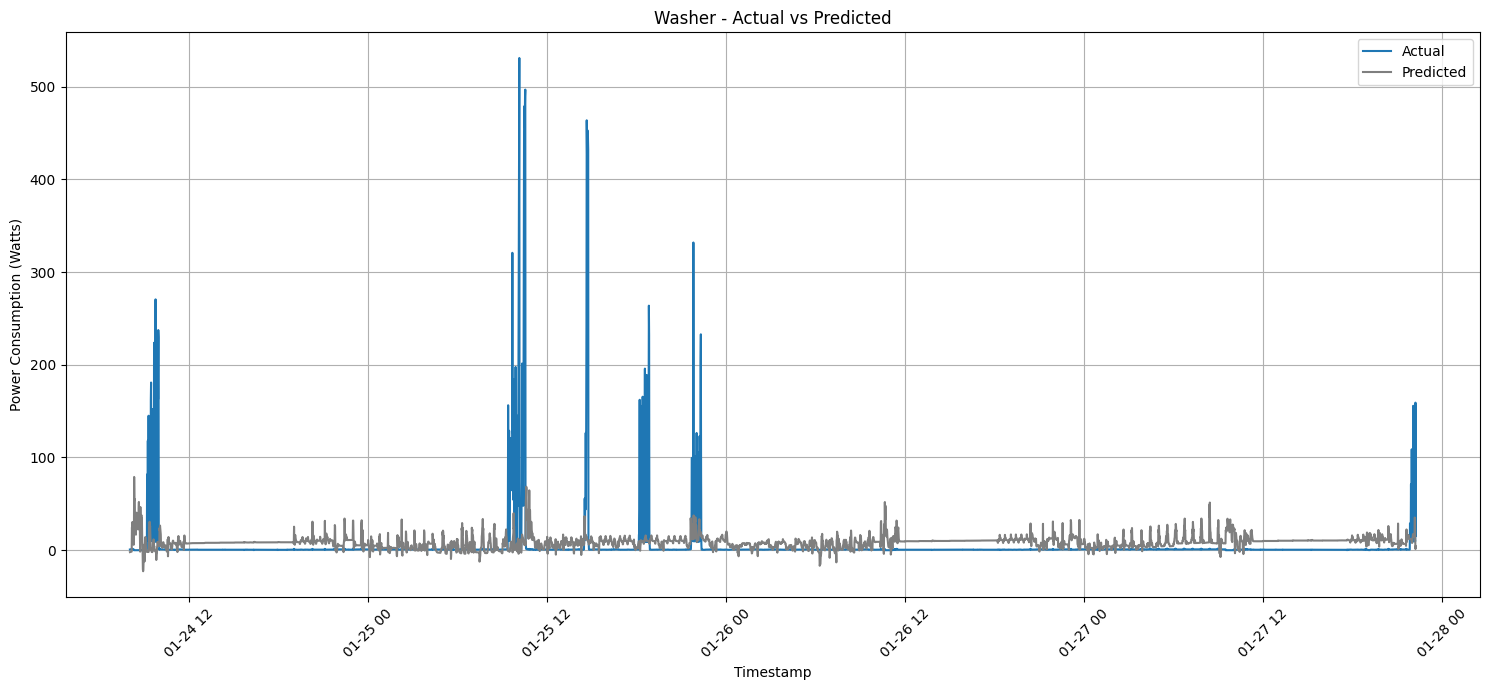

<ipython-input-100-33ce669e3149>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


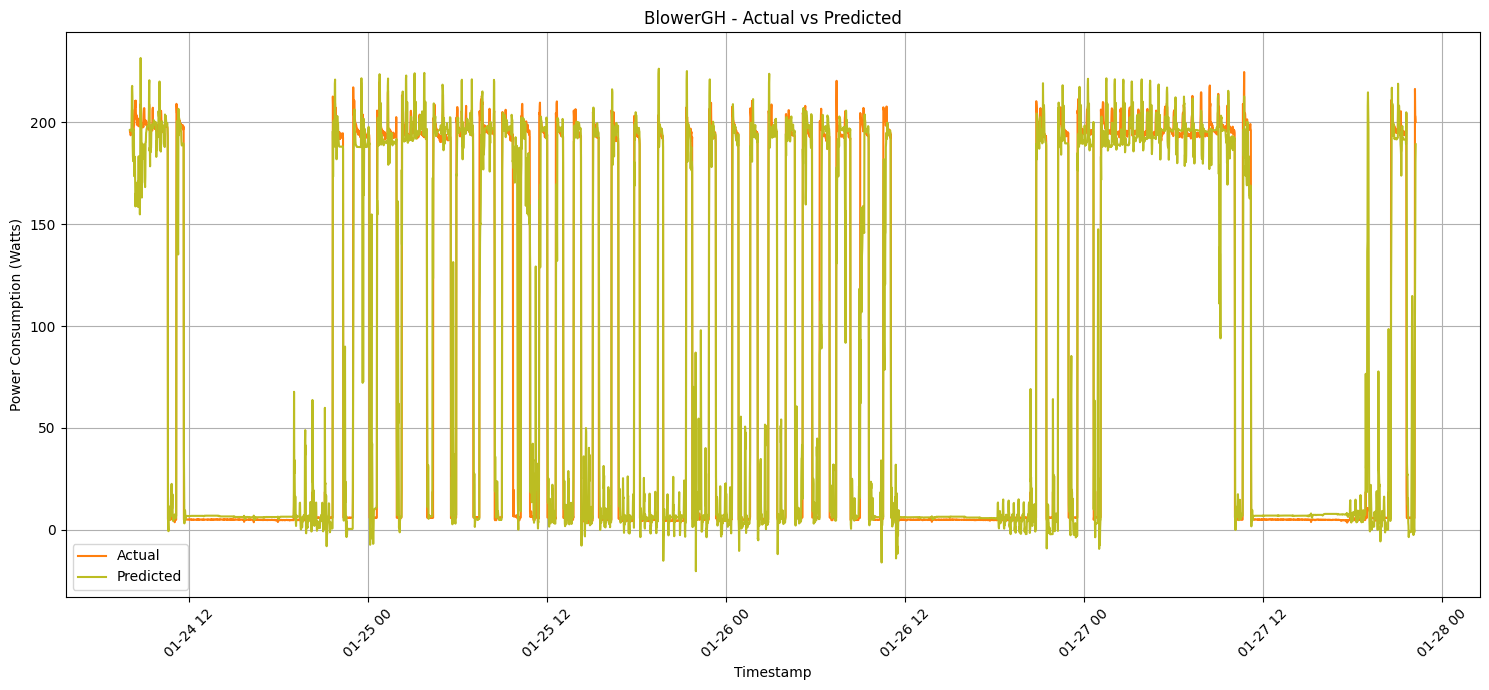

<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


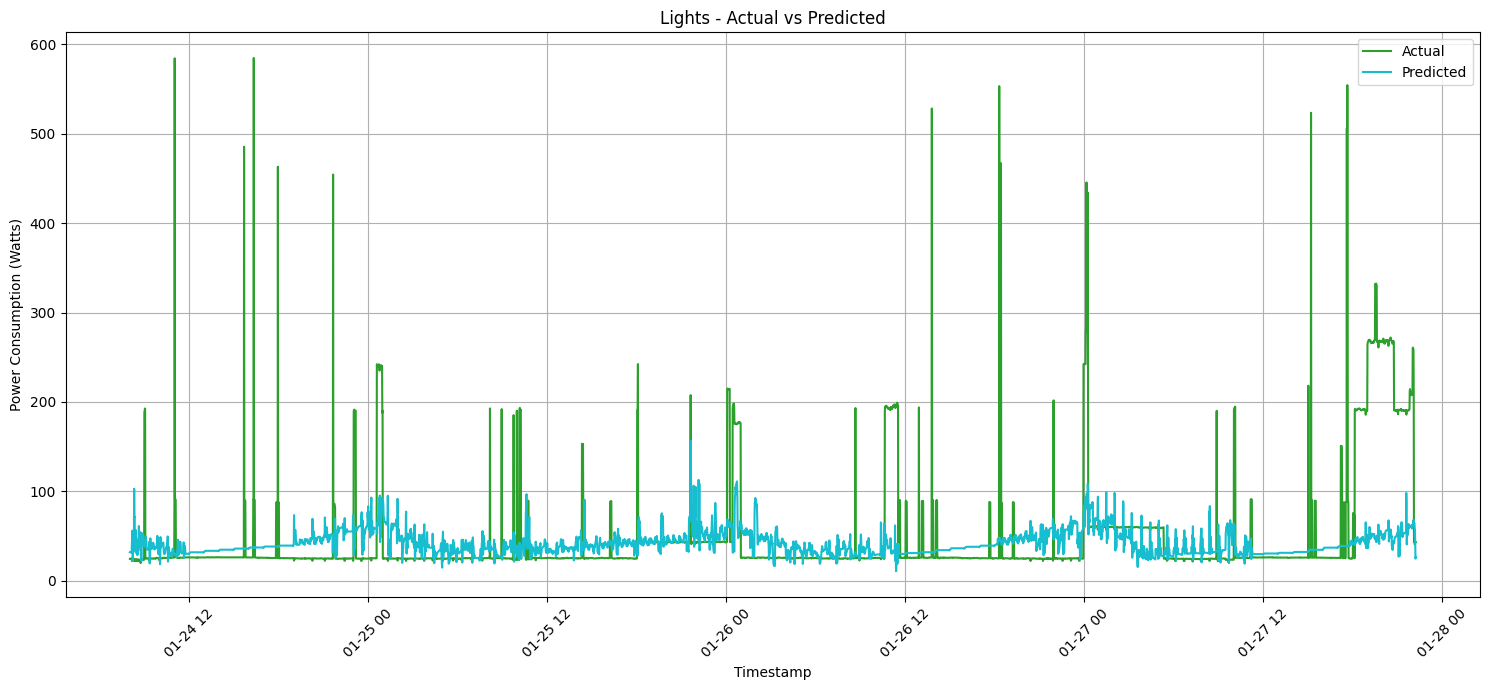

<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


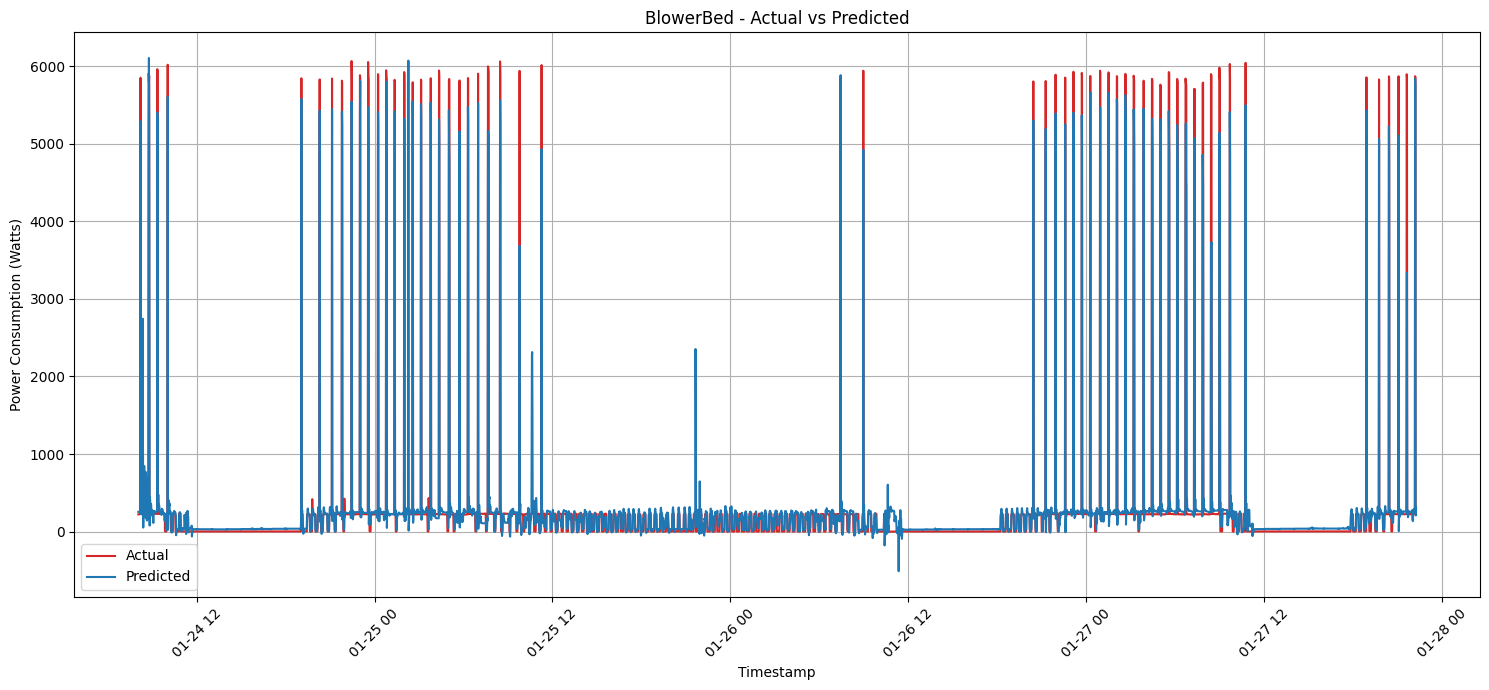

<ipython-input-100-33ce669e3149>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


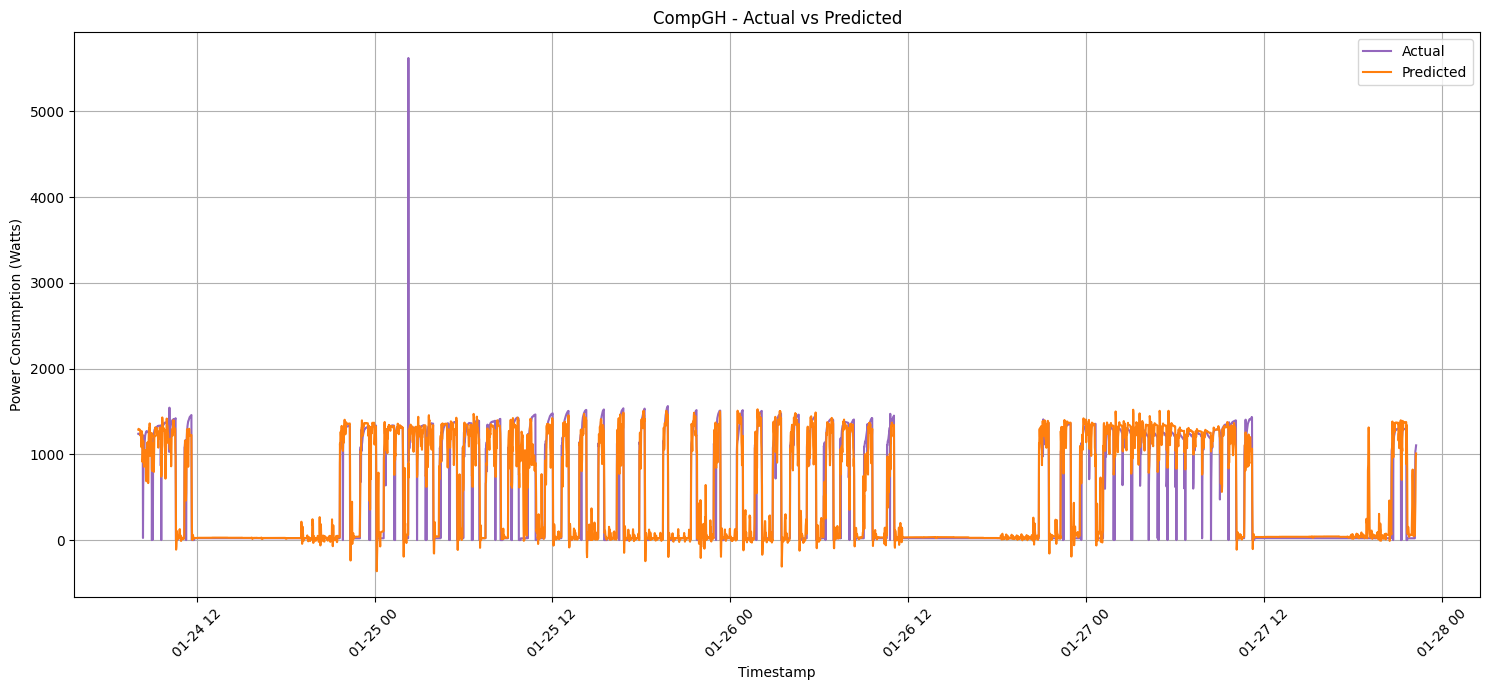

<ipython-input-100-33ce669e3149>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


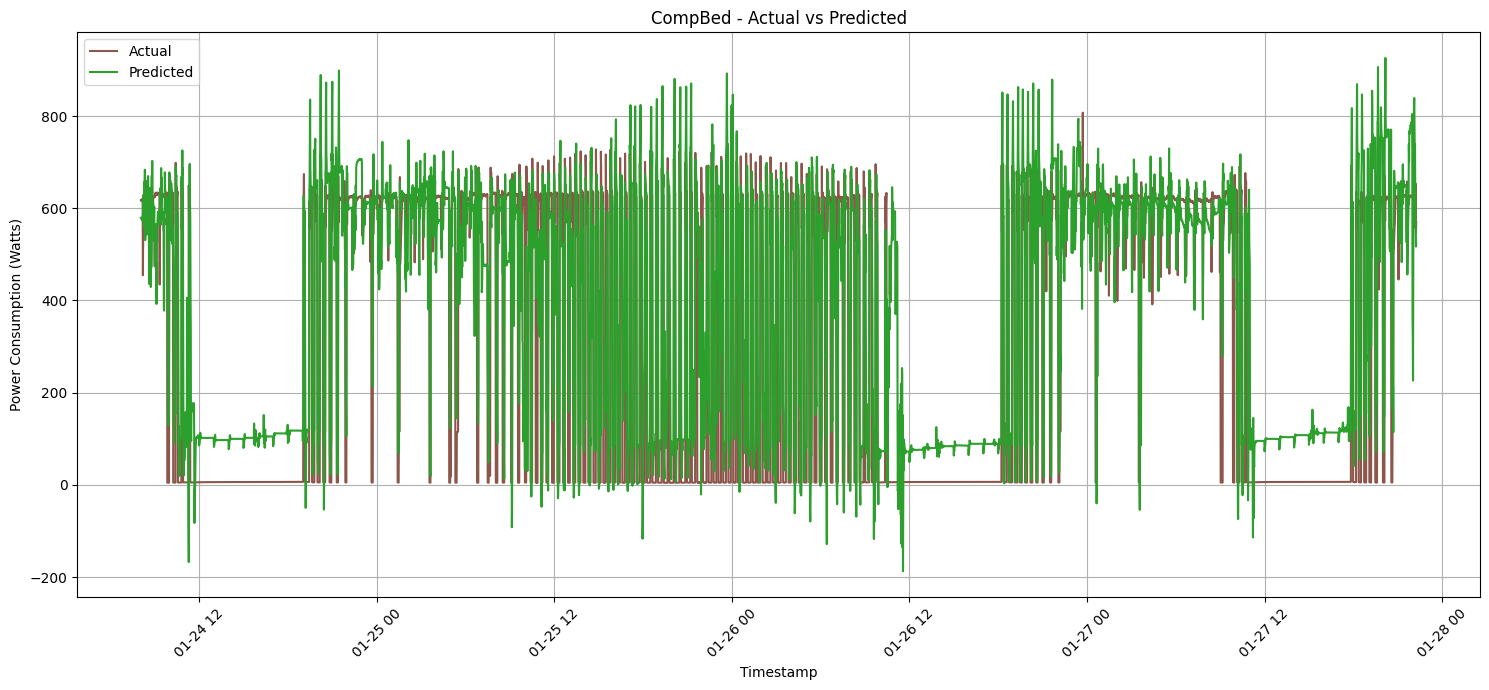

<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


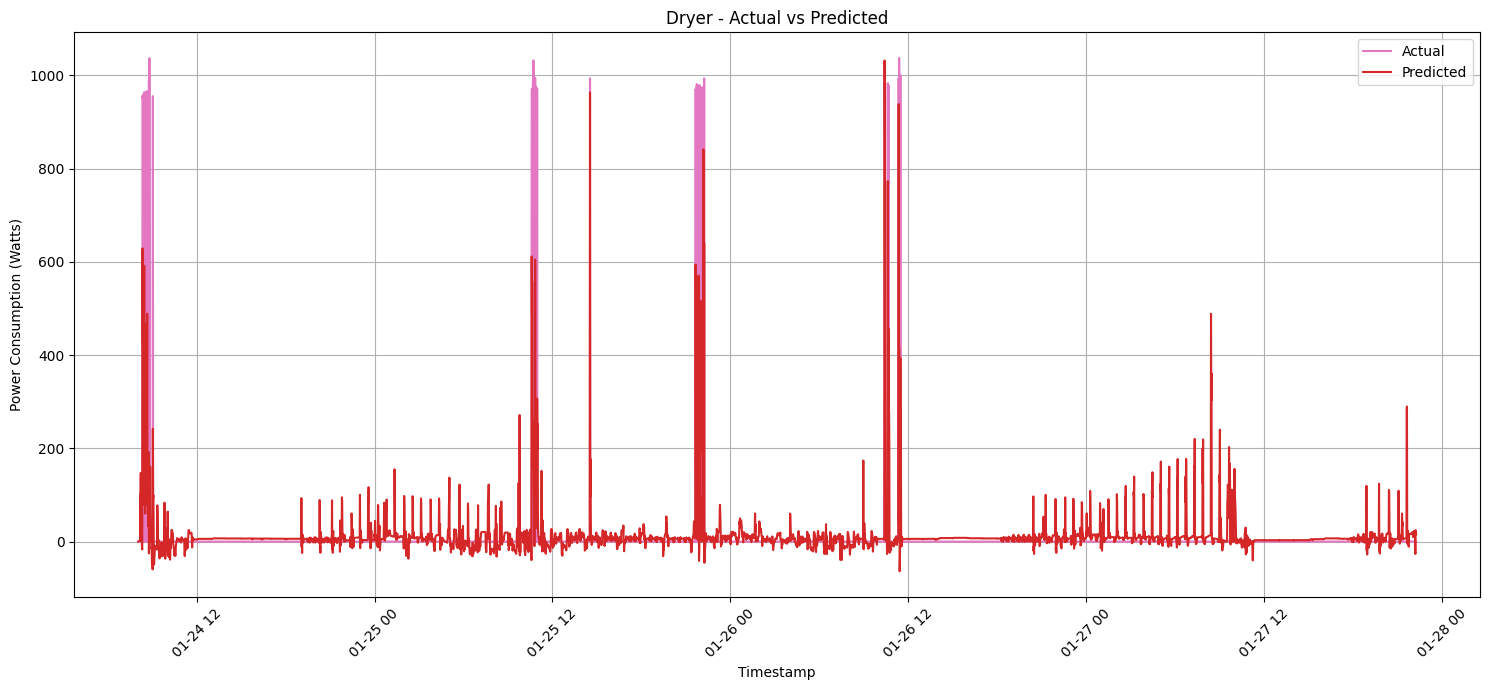

<ipython-input-100-33ce669e3149>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


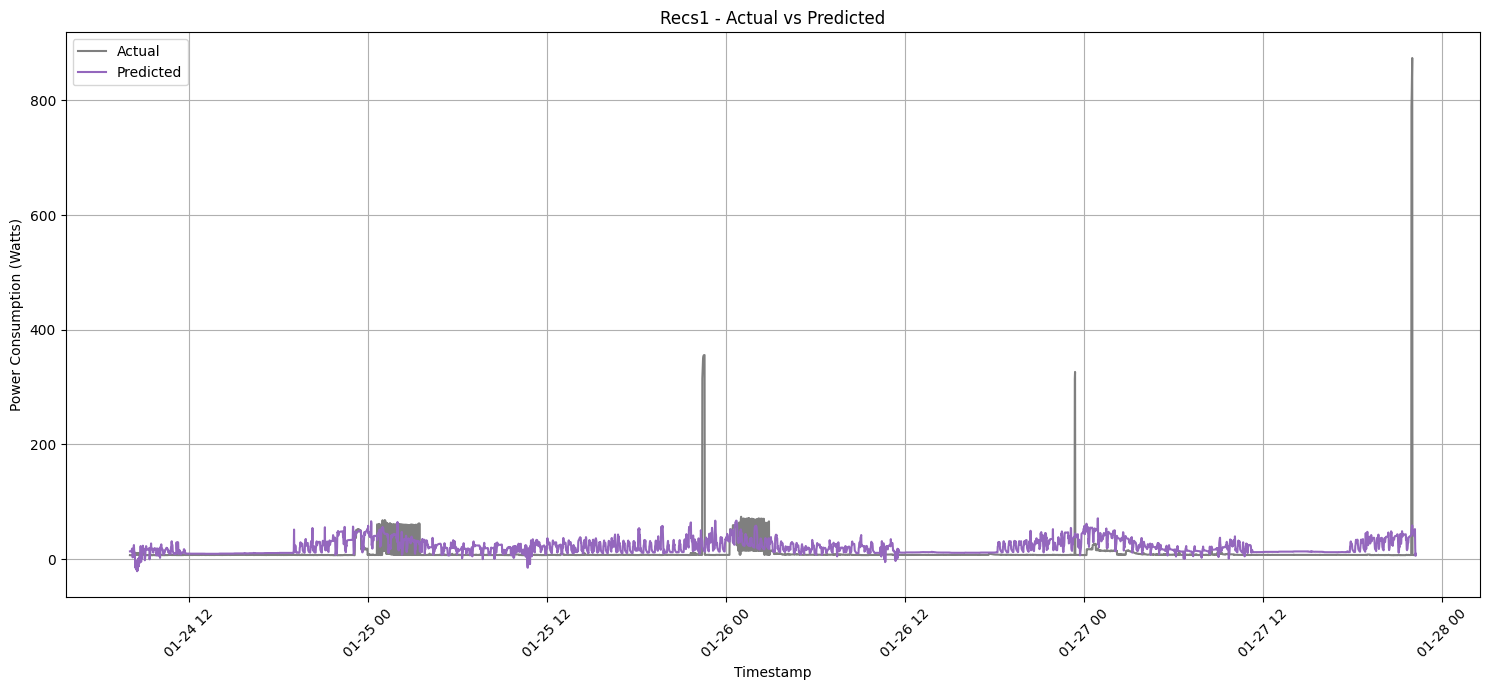

<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


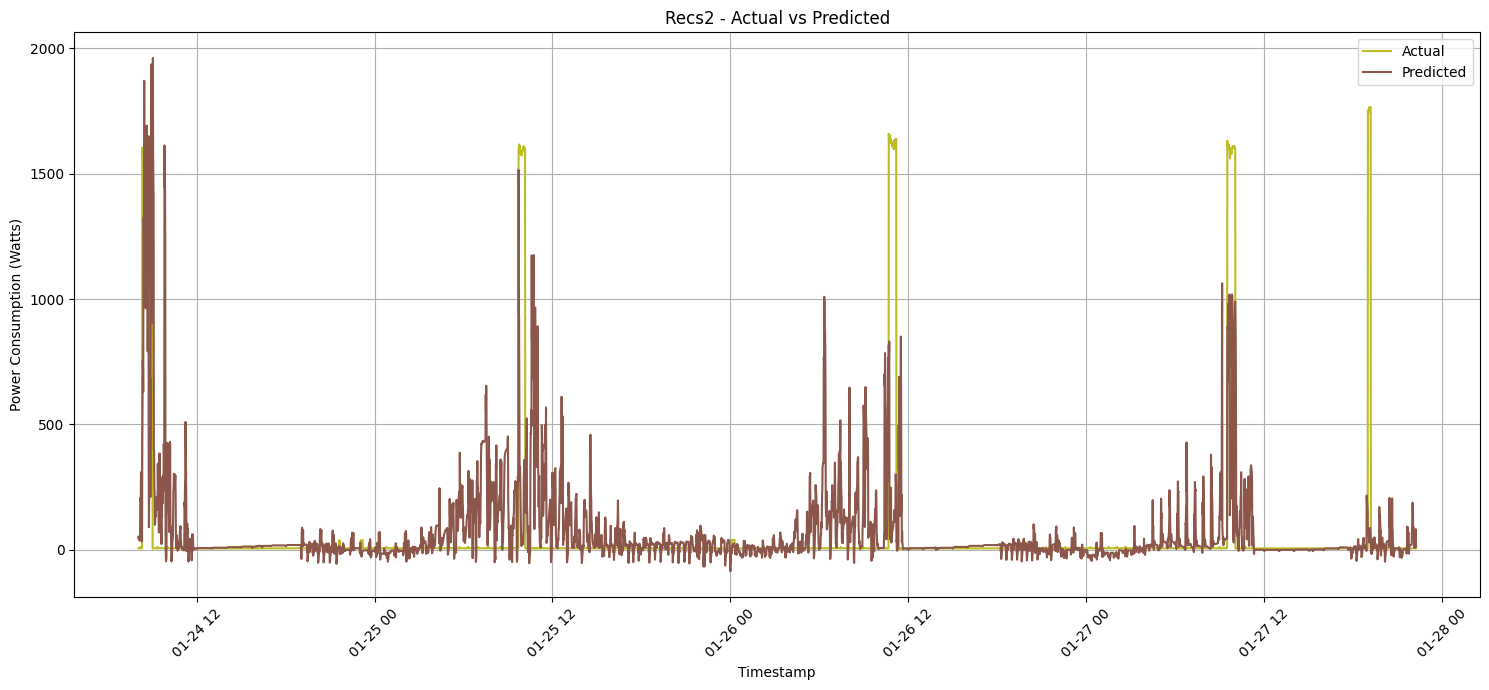

<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


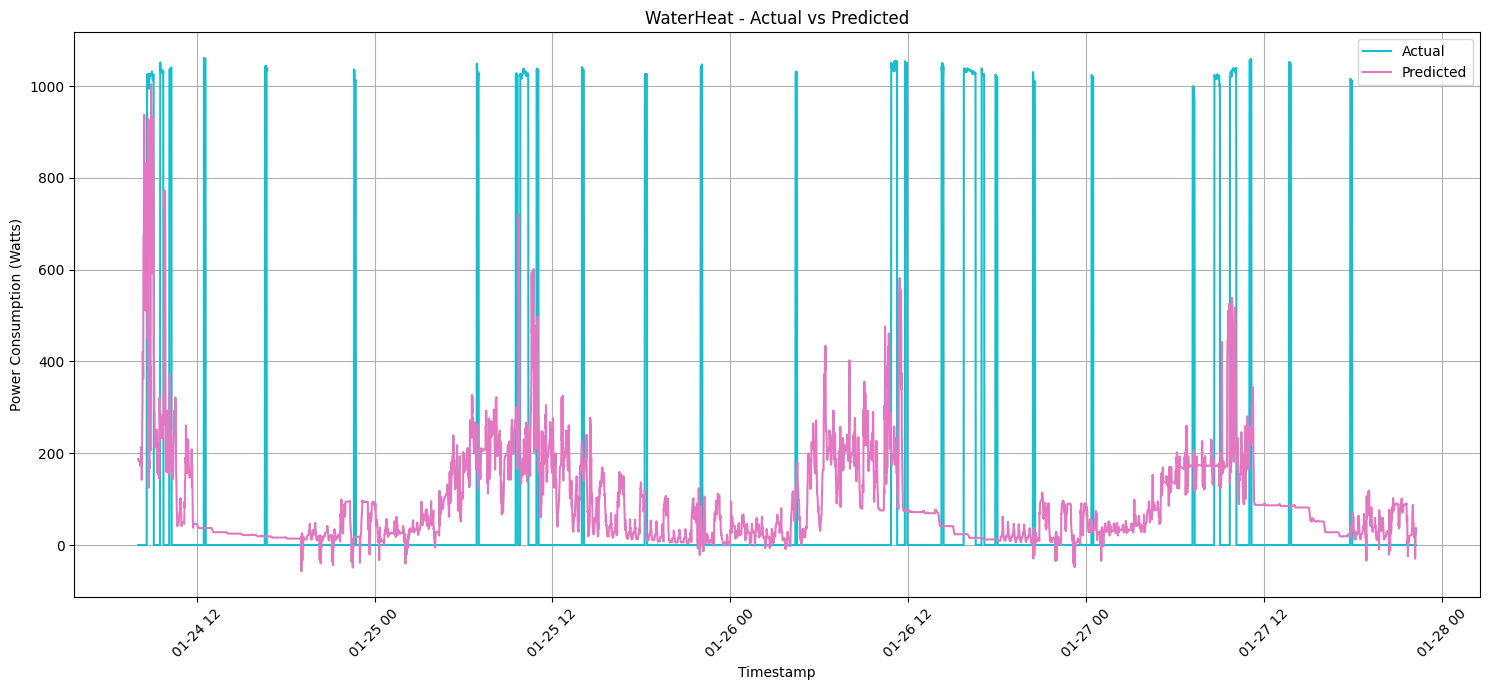

<ipython-input-100-33ce669e3149>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-100-33ce669e3149>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


In [ ]:
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back in Watts instead of normalized
predicted_values = scaler_y.inverse_transform(predictions)
actual_values = scaler_y.inverse_transform(y_test)

# Extract timestamps for test
test_timestamps = data['Timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeat']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])


for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate actual and predicted total power in watts for the current appliance
    actual_total = actual_values[:, idx].sum()
    predicted_total = predicted_values[:, idx].sum()

    #This was using simple error percentage, switch to MAPE
    # Calculate the percentage error for the current appliance
    percentage_error = abs(((actual_total - predicted_total) / actual_total) * 100)

    # Calculate the Mean Absolute Percentage Error (MAPE) for the current appliance
    absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
    mape = np.mean(absolute_percentage_error) * 100

    # some MAPE value are extremely high due to a 0 or near 0 value for the actual at a certain point

    # Calculate the Root Mean Square Error (RMSE) for the current appliance
    rmse = np.sqrt(np.mean((actual_values[:, idx] - predicted_values[:, idx]) ** 2))

    # Calculate the Mean Absolute Error (MAE) for the current appliance
    mae = np.mean(np.abs(actual_values[:, idx] - predicted_values[:, idx]))


    # Append the results to the DataFrame
    results_df = results_df.append({'Appliance': appliance,
                                    'Actual Total (Watts)': actual_total,
                                    'Predicted Total (Watts)': predicted_total,
                                    'Percentage Error': percentage_error,
                                    'MAPE': mape,
                                    'RMSE': rmse,
                                    'MAE': mae},
                                   ignore_index=True)